# Import Modules

In [1]:
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

import os
import pickle
import numpy as np
from keras.applications.densenet import DenseNet121, preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud

# Extract Image Features

In [4]:
# load DenseNet121 model
model = DenseNet121(weights='imagenet')
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
# Extract features from images using a pre-trained model
features = {}
directory = os.path.join('Images')

# Loop over images in the directory
for img_name in os.listdir(directory):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for the model
    image = preprocess_input(image)
    #img = img / 255.0
    #img = (img - mean) / std

    # Extract features from the image using the model
    feature = model.predict(image, verbose=0)

    # Get the image ID from the file name
    image_id = img_name.split('.')[0]

    # Store the image features in the dictionary
    features[image_id] = feature

In [ ]:
# store features in pickle
#pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [12]:
# load features from pickle
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [23]:
with open(os.path.join('captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [24]:
# Create a mapping between image IDs and their captions
mapping = {}

# Process each line in the captions document
for line in captions_doc.split('\n'):
    
    # Split the line by comma to extract the image ID and the caption
    tokens = line.split(',')

    # Skip the line if it doesn't have at least two tokens
    if len(line) < 2:
        continue

    # Extract the image ID and caption from the tokens
    image_id, caption = tokens[0], tokens[1:]

    # Remove the file extension from the image ID
    image_id = image_id.split('.')[0]

    # Convert the caption list to a string
    caption = " ".join(caption)

    # Create a new list for the image ID if it doesn't exist in the mapping
    if image_id not in mapping:
        mapping[image_id] = []

    # Add the caption to the list of captions for the image ID
    mapping[image_id].append(caption)

In [25]:
mapping

{'1000092795': [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  '" Two young   White males are outside near many bushes ."',
  ' Two men in green shirts are standing in a yard .',
  ' A man in a blue shirt standing in a garden .',
  ' Two friends enjoy time spent together .'],
 '10002456': [' Several men in hard hats are operating a giant pulley system .',
  ' Workers look down from up above on a piece of equipment .',
  ' Two men working on a machine wearing hard hats .',
  ' Four men on top of a tall structure .',
  ' Three men on a large rig .'],
 '1000268201': [' A child in a pink dress is climbing up a set of stairs in an entry way .',
  ' A little girl in a pink dress going into a wooden cabin .',
  ' A little girl climbing the stairs to her playhouse .',
  ' A little girl climbing into a wooden playhouse ',
  ' A girl going into a wooden building .'],
 '1000344755': [' Someone in a blue shirt and hat is standing on stair and leaning agai

In [26]:
len(mapping)

31783

In [27]:
mapping['490870']

[" A long journey has a small child passed out in a caring adult 's lap .",
 ' Blond children sleep on an adults lap as they ride on a bus .',
 ' Two blond-haired children are asleep on some kind of vessel .',
 " Two children sleep on a man 's lap .",
 ' Two children in bed sleeping .']

## Preprocess Text Data

In [28]:
# Preprocess captions in the mapping
for key, captions in mapping.items():

    # Loop over each caption for the image ID
    for i in range(len(captions)):
        
        # Take one caption at a time
        caption = captions[i]

        # Convert the caption to lowercase
        caption = caption.lower()

        # Remove digits, special characters, etc.,
        caption = caption.replace('[^A-Za-z]', '')

        # Remove additional spaces
        caption = caption.replace('\s+', ' ')

        # Add start and end tags to the caption
        caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'

        # Update the caption in the list of captions for the image ID
        captions[i] = caption

In [13]:
#mapping

In [14]:
# after preprocess of text
mapping['490870']

["start long journey has small child passed out in caring adult 's lap end",
 'start blond children sleep on an adults lap as they ride on bus end',
 'start two blond-haired children are asleep on some kind of vessel end',
 "start two children sleep on man 's lap end",
 'start two children in bed sleeping end']

In [30]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [31]:
len(all_captions)

158915

In [33]:
all_captions[3:10]

['start man in blue shirt standing in garden end',
 'start two friends enjoy time spent together end',
 'start several men in hard hats are operating giant pulley system end',
 'start workers look down from up above on piece of equipment end',
 'start two men working on machine wearing hard hats end',
 'start four men on top of tall structure end',
 'start three men on large rig end']

In [57]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [45]:
tokenizer.word_index

{'end': 1,
 'start': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'and': 6,
 'man': 7,
 'is': 8,
 'of': 9,
 'with': 10,
 'woman': 11,
 'two': 12,
 'are': 13,
 'to': 14,
 'people': 15,
 'at': 16,
 'an': 17,
 'wearing': 18,
 'shirt': 19,
 'white': 20,
 'young': 21,
 'black': 22,
 'while': 23,
 'his': 24,
 'blue': 25,
 'red': 26,
 'girl': 27,
 'sitting': 28,
 'men': 29,
 'boy': 30,
 'standing': 31,
 'dog': 32,
 'playing': 33,
 'street': 34,
 'group': 35,
 'down': 36,
 'front': 37,
 'her': 38,
 'walking': 39,
 'holding': 40,
 'one': 41,
 'water': 42,
 'three': 43,
 'by': 44,
 'women': 45,
 'green': 46,
 'up': 47,
 'looking': 48,
 'child': 49,
 'as': 50,
 'for': 51,
 'little': 52,
 'large': 53,
 'outside': 54,
 'brown': 55,
 'yellow': 56,
 'person': 57,
 'children': 58,
 'through': 59,
 'hat': 60,
 'from': 61,
 'their': 62,
 'other': 63,
 'ball': 64,
 'small': 65,
 'next': 66,
 'into': 67,
 'over': 68,
 'some': 69,
 'dressed': 70,
 'out': 71,
 'another': 72,
 'running': 73,
 'building': 74,
 'jacket'

In [58]:
vocab_size

18312

In [54]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

# Visualization

In [64]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize_ngrams(mapping, n=2, top_n=30, most_least='most'):
    # create a list of all the n-graams in the corpus
    all_ngrams = []
    for key, captions in mapping.items():
        for caption in captions:
            # split the caption into n-grams
            words = caption.split()
            ngrams = []
            
            for i in range(len(words) - n + 1):
                ngram = ' '.join(words[i:i+n]) 
                ngrams.append(ngram)
            all_ngrams.extend(ngrams)

    # count the frequency of each n-gram
    ngram_counts = Counter(all_ngrams)

    # plot the top n most frequent or least frequent n-grams depending on the value of most_least
    if most_least == 'most':
        ngrams = ngram_counts.most_common(top_n)
        labels, values = zip(*ngrams)
        indexes = range(top_n)
        plt.figure(figsize=(10, 8))
        plt.bar(indexes, values)
        plt.xticks(indexes, labels, rotation='vertical')
        plt.title('Top {} Most Frequent {}-grams'.format(top_n, n))
    elif most_least == 'least':

        ngrams = ngram_counts.most_common()[:-top_n-1:-1]
        labels, values = zip(*ngrams)
        indexes = range(top_n)
        plt.figure(figsize=(10, 8))
        plt.bar(indexes, values)
        plt.xticks(indexes, labels, rotation='vertical')
        plt.title('Top {} Least Frequent {}-grams'.format(top_n, n))
    else:
        raise ValueError("most_least parameter must be either 'most' or 'least'.")

    plt.show()

In [66]:
visualize_ngrams(mapping, n=1, top_n=10, most_least='most')

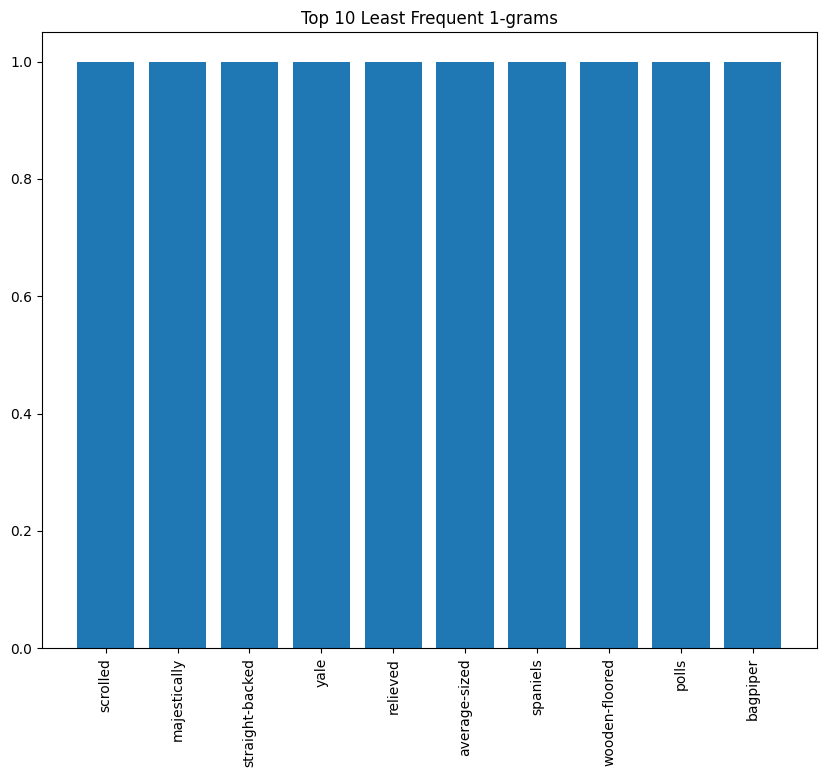

In [67]:
visualize_ngrams(mapping, n=1, top_n=10, most_least='least')

In [68]:
visualize_ngrams(mapping, n=2, top_n=10, most_least='most')

In [69]:
visualize_ngrams(mapping, n=2, top_n=10, most_least='least')

In [70]:
visualize_ngrams(mapping, n=3, top_n=10, most_least='most')

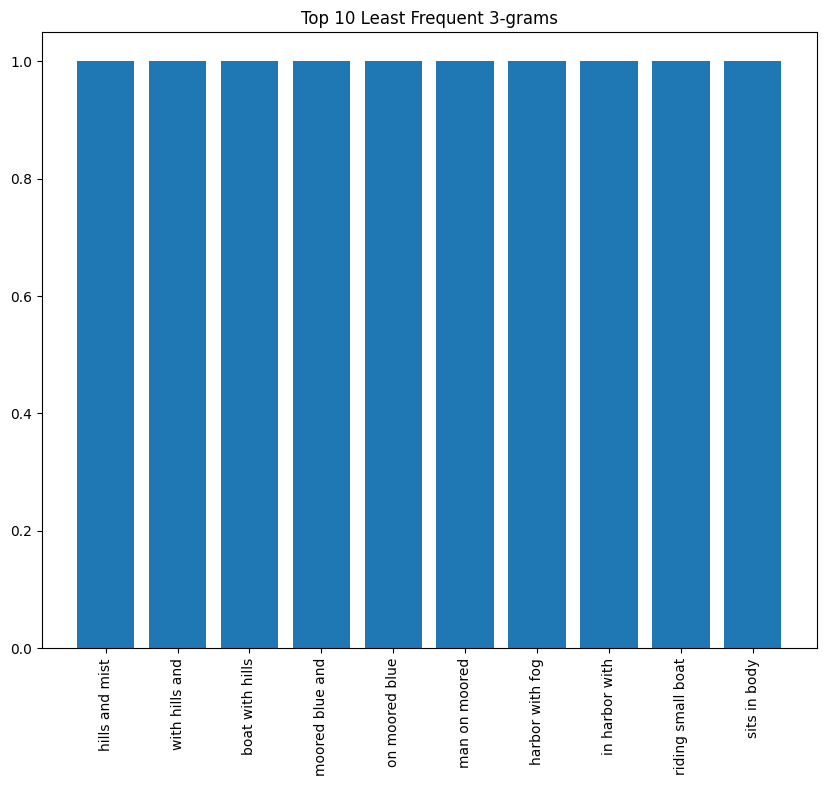

In [71]:
visualize_ngrams(mapping, n=3, top_n=10, most_least='least')

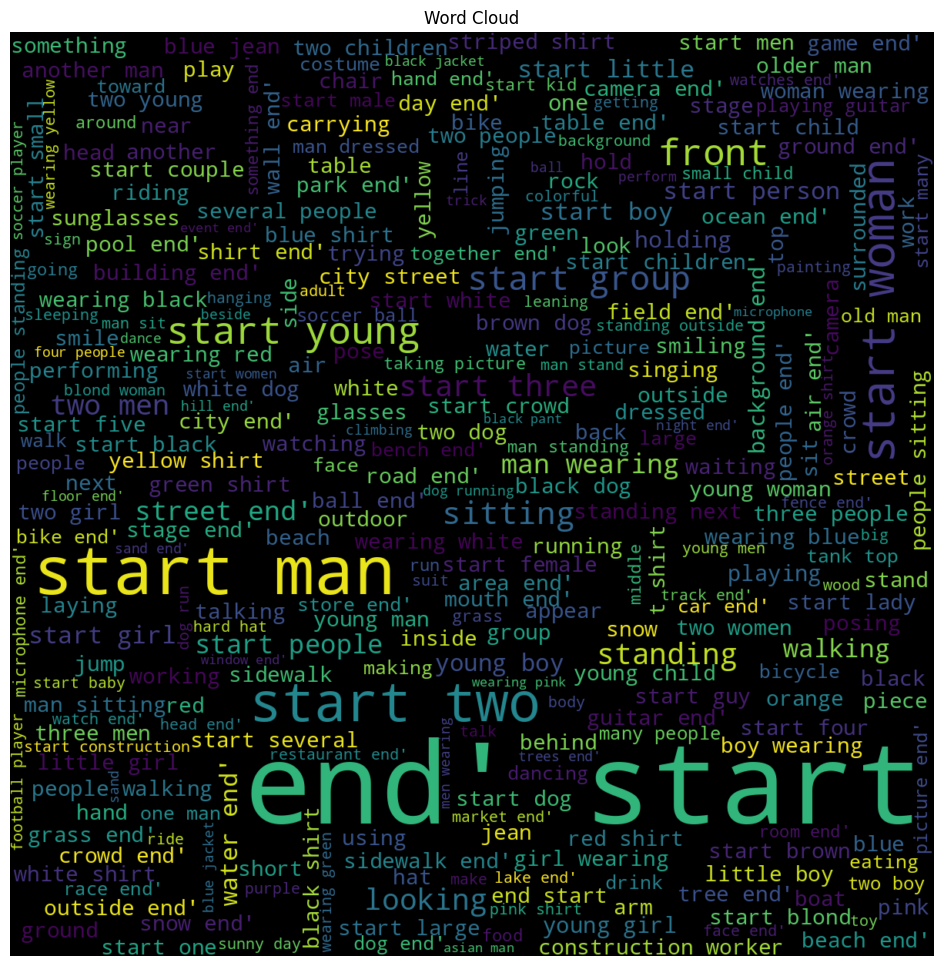

In [72]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=1200, min_font_size = 2, max_words=300).generate(str(all_captions))
# Display the generated image:
plt.figure(figsize=(12,12))
plt.title('Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Train Test Split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.95)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
split

30193

In [20]:
train

['1000092795',
 '10002456',
 '1000268201',
 '1000344755',
 '1000366164',
 '1000523639',
 '1000919630',
 '10010052',
 '1001465944',
 '1001545525',
 '1001573224',
 '1001633352',
 '1001773457',
 '1001896054',
 '100197432',
 '100207720',
 '1002674143',
 '1003163366',
 '1003420127',
 '1003428081',
 '100444898',
 '1005216151',
 '100577935',
 '1006452823',
 '100652400',
 '1007129816',
 '100716317',
 '1007205537',
 '1007320043',
 '100759042',
 '10082347',
 '10082348',
 '100845130',
 '10090841',
 '1009434119',
 '1009692167',
 '101001624',
 '1010031975',
 '1010087179',
 '1010087623',
 '10101477',
 '1010470346',
 '1010673430',
 '101093029',
 '101093045',
 '1011572216',
 '1012150929',
 '1012212859',
 '1012328893',
 '101262930',
 '1013536888',
 '101362133',
 '101362650',
 '1014609273',
 '101471792',
 '1014785440',
 '1015118661',
 '1015584366',
 '101559400',
 '1015712668',
 '10160966',
 '101654506',
 '1016626169',
 '101669240',
 '1016887272',
 '1017675163',
 '1018057225',
 '1018148011',
 '101859883'

In [21]:
test

['74137268',
 '7414768750',
 '7416738744',
 '7417714642',
 '742073622',
 '7420874336',
 '7420985602',
 '7421074812',
 '74213476',
 '7421349720',
 '7422016352',
 '7422345584',
 '7422429952',
 '7423137882',
 '74244744',
 '7425128736',
 '7425257042',
 '742586128',
 '7426852574',
 '7428276152',
 '7428316382',
 '7428579548',
 '7430272380',
 '7430281548',
 '7430282012',
 '7430283024',
 '74306574',
 '7431651498',
 '7432698546',
 '7432995570',
 '7433123648',
 '7434147482',
 '743571049',
 '7436111546',
 '7436121372',
 '743635194',
 '7438195398',
 '7438344154',
 '7439117786',
 '74437575',
 '7443807824',
 '7443809320',
 '7444421214',
 '7444755272',
 '7445213794',
 '7446693604',
 '7446761184',
 '7453903222',
 '7454547004',
 '7455508610',
 '745563422',
 '7456119772',
 '745880539',
 '745966757',
 '7460584428',
 '7461670356',
 '74635420',
 '7463856746',
 '7464079150',
 '74641706',
 '746568292',
 '7465714818',
 '7466310132',
 '746787916',
 '7468150262',
 '7468663062',
 '7470011060',
 '74706255',
 '747

In [ ]:
seq = tokenizer.texts_to_sequences([caption])[0]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images

    # Initialize empty lists to store input and output sequences
    X1, X2, y = list(), list(), list()
    # Initialize a counter to keep track of the number of batches

    n = 0
    # Generate batches of data indefinitely
    while 1:

        # Loop over each image ID in the data keys
        for key in data_keys:
            n += 1

            # Get the captions for the image ID
            captions = mapping[key]
            # Process each caption for the image ID
            for caption in captions:

                 # Encode the caption sequence using the tokenizer
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                # Split the sequence into input and output pairs
                for i in range(1, len(seq)):

                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad the input sequence to the maximum length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # Encode the output sequence as one-hot-endcoded vectors    
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store the input and output sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            # Check if the batch size has been reached
            if n == batch_size:
                # Convert the input and output sequences to NumPy arrays
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                # Yield the batch of data as a tuple of inputs and outputs
                yield [X1, X2], y

                # Reset the input and output sequence lists and the batch counter
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

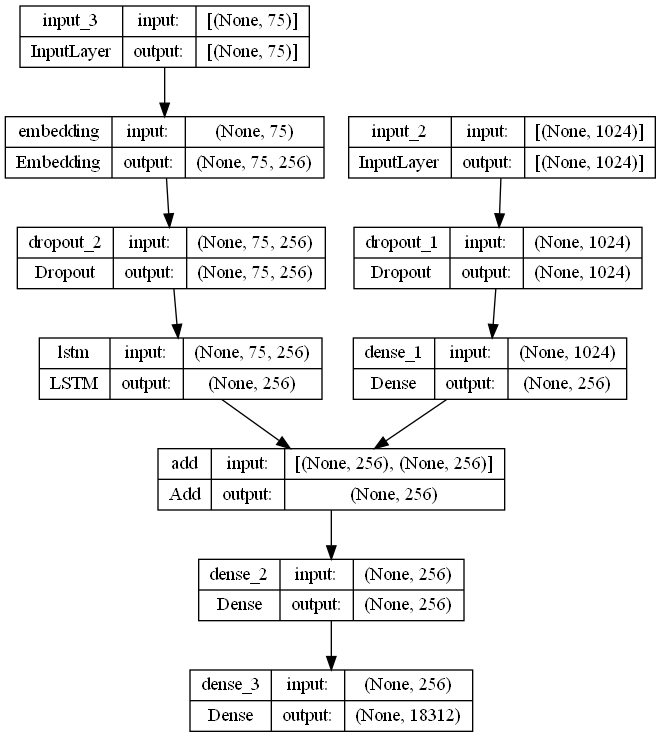

In [22]:
# Define the encoder model
# Image feature layers
image_input = Input(shape=(1024,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
caption_input = Input(shape=(max_length,))
caption_embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_dropout = Dropout(0.4)(caption_embedding)
caption_lstm = LSTM(256)(caption_dropout)

# Combine the feature layers
decoder_add = add([image_dense, caption_lstm])
decoder_dense1 = Dense(256, activation='relu')(decoder_add)

# Output layer
decoder_output = Dense(vocab_size, activation='softmax')(decoder_dense1)

# Define the model
model = Model(inputs=[image_input, caption_input], outputs=decoder_output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Plot the model architecture
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 20
batch_size = 32
train_steps = len(train) // batch_size
val_steps = len(test) // batch_size
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    # create data generator
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(train_generator, 
              epochs=1,
                steps_per_epoch=train_steps,
                validation_data=val_generator,
            validation_steps=val_steps,
              verbose=1)
    model.save(f'models/model_checkpoint_{i+1}.h5')
    print ('Epoch:',i+1,'/', epochs)
    print('model saved as',f'models/model_checkpoint_{i+1}.h5')

943/943 [==============================] - 403s 422ms/step - loss: 4.6484 - accuracy: 0.2209 - val_loss: 4.1787 - val_accuracy: 0.2579
Epoch: 1 / 20
model saved as models/model_checkpoint_1.h5
943/943 [==============================] - 392s 416ms/step - loss: 3.8084 - accuracy: 0.2837 - val_loss: 3.9124 - val_accuracy: 0.2838
Epoch: 2 / 20
model saved as models/model_checkpoint_2.h5
943/943 [==============================] - 390s 414ms/step - loss: 3.5610 - accuracy: 0.3017 - val_loss: 3.8218 - val_accuracy: 0.2945
Epoch: 3 / 20
model saved as models/model_checkpoint_3.h5
943/943 [==============================] - 391s 415ms/step - loss: 3.4041 - accuracy: 0.3131 - val_loss: 3.7861 - val_accuracy: 0.3008
Epoch: 4 / 20
model saved as models/model_checkpoint_4.h5
943/943 [==============================] - 390s 413ms/step - loss: 3.2874 - accuracy: 0.3219 - val_loss: 3.7841 - val_accuracy: 0.3057
Epoch: 5 / 20
model saved as models/model_checkpoint_5.h5
943/943 [==========================

# train with no for loop

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model_no_loop.h5', verbose=1, save_best_only=True)

epochs = 25
batch_size = 32
train_steps = len(train) // batch_size
val_steps = len(test) // batch_size
train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# train the model
history= model.fit(train_generator, 
                   epochs=epochs, 
                   steps_per_epoch=train_steps,
                   validation_data=val_generator,
                   validation_steps=val_steps, 
                      callbacks=[anne, checkpoint])
model.save('models/model_no_loop.h5')

Epoch 1/20
943/943 [==============================] - ETA: 0s - loss: 4.6545 - accuracy: 0.2207
Epoch 1: val_loss improved from inf to 4.17840, saving model to best_model_no_loop.h5
943/943 [==============================] - 401s 421ms/step - loss: 4.6545 - accuracy: 0.2207 - val_loss: 4.1784 - val_accuracy: 0.2588 - lr: 0.0010
Epoch 2/20
943/943 [==============================] - ETA: 0s - loss: 3.8085 - accuracy: 0.2838
Epoch 2: val_loss improved from 4.17840 to 3.91318, saving model to best_model_no_loop.h5
943/943 [==============================] - 387s 410ms/step - loss: 3.8085 - accuracy: 0.2838 - val_loss: 3.9132 - val_accuracy: 0.2839 - lr: 0.0010
Epoch 3/20
943/943 [==============================] - ETA: 0s - loss: 3.5595 - accuracy: 0.3020
Epoch 3: val_loss improved from 3.91318 to 3.81762, saving model to best_model_no_loop.h5
943/943 [==============================] - 391s 414ms/step - loss: 3.5595 - accuracy: 0.3020 - val_loss: 3.8176 - val_accuracy: 0.2954 - lr: 0.0010
Ep

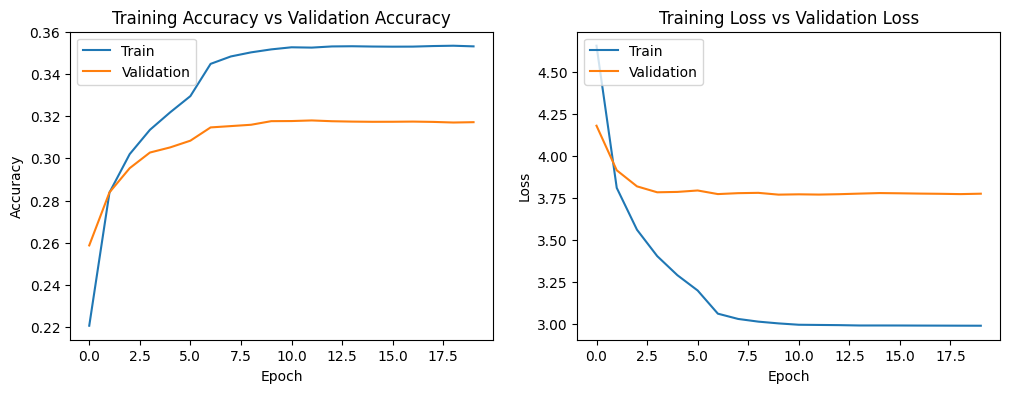

In [31]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Load the saved models

In [18]:
from keras.models import load_model
best_model = load_model('best_model_no_loop.h5')
model = load_model('models\model_checkpoint_20.h5')

## Generate Captions for the Image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start' 
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
      
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu

def bleu_score(model, test_data, mapping):
    # Initialize empty lists to store actual and predicted captions
    actual_captions, predicted_captions = list(), list()

    # Loop over each image in the test set
    for key in test_data:
        # Get the actual captions for the image
        actual_captions_for_image = mapping[key]

        # Predict the caption for the image
        predicted_caption = predict_caption(model, features[key], tokenizer, max_length)

        # Split the actual and predicted captions into words
        actual_words = [caption.split() for caption in actual_captions_for_image]
        predicted_words = predicted_caption.split()

        # Append the actual and predicted captions to the corresponding lists
        actual_captions.append(actual_words)
        predicted_captions.append(predicted_words)

    # Calculate the BLEU score for n-gram weights 1 and 2
    print("BLEU-1: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

# without for loop

In [28]:
bleu_score(model)

BLEU-1: 0.554523
BLEU-2: 0.309724


# For loop models

In [37]:
bleu_score(model)

BLEU-1: 0.590318
BLEU-2: 0.337293


In [38]:
bleu_score(best_model)

BLEU-1: 0.576226
BLEU-2: 0.328951


# Visualize the Results

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name, model):
    # Get the image ID from the image name
    image_id = image_name.split('.')[0]

    # Load the image from the file
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)

    # Get the actual captions for the image from the mapping
    captions = mapping[image_id]

    # Print the actual captions
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption for the image using the trained model
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    # Print the predicted caption
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Display the image using Matplotlib
    plt.imshow(image)

---------------------Actual---------------------
start man wearing black leather jackets holds two microphones to his mouth while standing in front of orange and white sign end
start man on stage talking through microphone in black leather jacket end
start man in black leather jacket singing in to microphone end
start man in leather jacket sings into two microphones end
start man in black leather jacket is singing end
--------------------Predicted--------------------
start man in black shirt and black pants is singing into microphone end


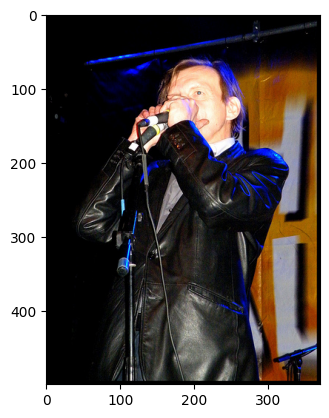

In [24]:
generate_caption("7428579548.jpg", best_model)

---------------------Actual---------------------
start man on bicycle wearing cycle gear riding at fast past down paved trail surrounded by tree 's and grass ." end
start bicyclist rounding curve at high velocity end
start bicycle racer participates in race end
start guy riding his bike on road end
start single person riding bike end
--------------------Predicted--------------------
start man in blue shirt and helmet riding bike end


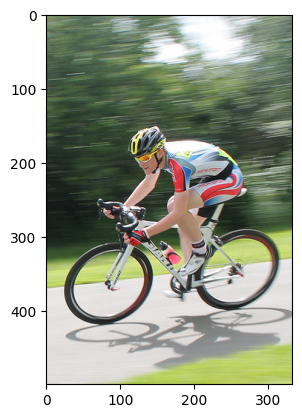

In [26]:
generate_caption("7432995570.jpg", best_model)

---------------------Actual---------------------
start five men playing competitive game of basketball with the man in the black tank top and black shorts in possession of the ball end
start member of the blue devils youth basketball team controls ball in game against the crusaders end
start group of teenagers in variety of jerseys maneuver for control of basketball end
start some boys are playing basketball on court end
start basketball game between two schools end
--------------------Predicted--------------------
start two men are playing basketball in front of crowd end


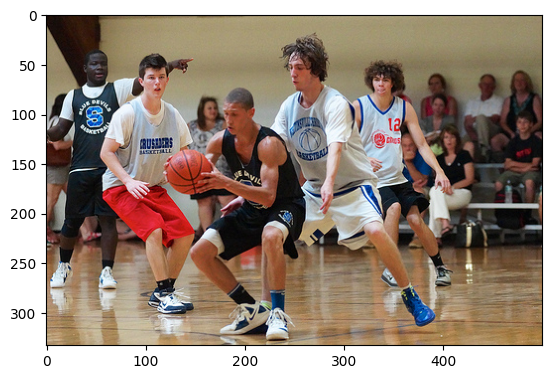

In [27]:
generate_caption("7589467042.jpg", best_model)

---------------------Actual---------------------
start group of women in the foreground wear pink and people to the right of them and behind them wear white as they perform ritual ." end
start gathering of women wearing white and pink in public square raising their arms end
start women dressed in pink and white clothing stand with arms pointed to the sky end
start asian women dressed in white and pink participate in some kind of festival end
start indian people dressed in magnificent bright colors conduct ritual end
--------------------Predicted--------------------
start group of people are standing in front of large building end


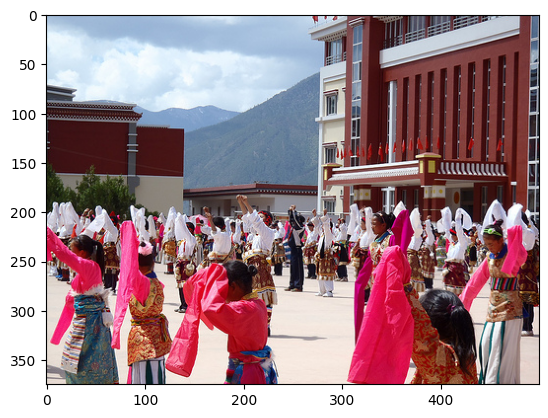

In [39]:
generate_caption("7595435150.jpg", best_model)

---------------------Actual---------------------
start group of marines walking down the road with american flags and other military flags end
start color guard representing the various arms of the armed services march in parade end
start military section of parade is marching with many different flags end
start marines dressing uniform walking in parade carrying their colors end
start soldiers march up the street during parade end
--------------------Predicted--------------------
start group of people are walking down the street end


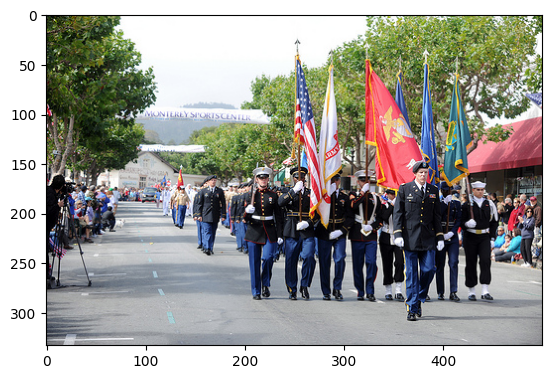

In [41]:
generate_caption("7517274630.jpg", best_model)

## Test with Real Image

In [29]:
DenseNet121_model = DenseNet121()
# restructure the model
DenseNet121_model = Model(inputs=DenseNet121_model.inputs, outputs=DenseNet121_model.layers[-2].output)

image_path = 'img.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for densenet
image = preprocess_input(image)
# extract features
feature = DenseNet121_model.predict(image, verbose=0)

1/1 [==============================] - 3s 3s/step


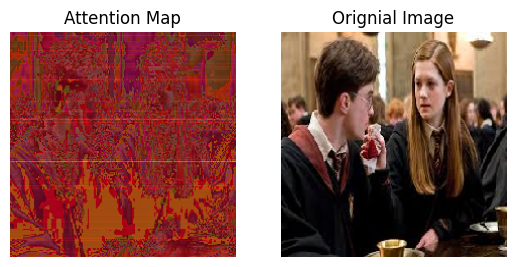

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.models import Model
import cv2
# Load the DenseNet121 model
DenseNet121_model_2 = DenseNet121(weights='imagenet')

# Create a new model that outputs the last convolutional layer
last_conv_layer = DenseNet121_model_2.get_layer('conv5_block16_concat')
last_conv_layer_model = Model(DenseNet121_model_2.inputs, last_conv_layer.output)

# Load the image and preprocess it
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Extract features from the image
features = last_conv_layer_model.predict(image)

# Calculate the weights for each channel in the feature map
weights = np.mean(features, axis=(1, 2))
weights = np.squeeze(weights)
weights = np.maximum(weights, 0)

# Resize the image and the attention map to theappropriate size for visualization
upsampled_image = np.uint8(255 * image[0])
upsampled_attention = cv2.resize(weights, (upsampled_image.shape[1], upsampled_image.shape[0]))
upsampled_attention = np.uint8(255 * upsampled_attention)
heatmap = cv2.applyColorMap(upsampled_attention, cv2.COLORMAP_JET)

# Overlay the heatmap on the image
alpha = 0.3
output_image = cv2.addWeighted(upsampled_image, alpha, heatmap, 1 - alpha, 0)


# Visualize the image and attention map
plt.subplot(1, 2, 1)
plt.title('Attention Map')
plt.imshow(output_image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title('Orignial Image')
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.axis('off')

plt.show()

In [31]:
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'start man in black shirt is speaking to another man in brown suit end'

start man in black shirt is speaking to another man in brown suit end


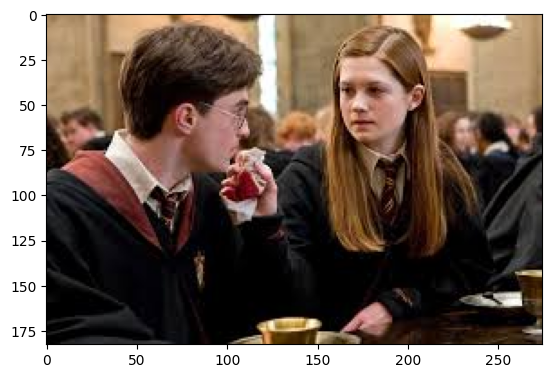

In [32]:
print(predict_caption(model, feature, tokenizer, max_length))
plt.imshow(load_img(image_path))